<a href="https://colab.research.google.com/github/elupuu/water-quality-ml22/blob/main/drinking_water_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.0 MB/s 


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.1 MB/s 


In [3]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import scipy as sc
import missingno as msno
import skopt
import shap
from sklearn.metrics import classification_report
from google.colab import files
from sklearn.model_selection import train_test_split
import copy
import xgboost as xgb
from sklearn.metrics import plot_roc_curve, auc, ConfusionMatrixDisplay

In [6]:
## Upload the kaggle api key
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
# Download the raw data
!chmod 600 /root/.kaggle/kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c copy-of-drinking-water-quality
!unzip copy-of-drinking-water-quality.zip

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
-rw-r--r-- 1 root root 63 Dec 12 19:25 kaggle.json
  0% 0.00/28.8k [00:00<?, ?B/s]
100% 28.8k/28.8k [00:00<00:00, 19.7MB/s]
Archive:  copy-of-drinking-water-quality.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
# Load data
train_all = pd.read_csv('train.csv')
test_all = pd.read_csv('test.csv')

# EDA, Train/val split

Text(0.5, 1.0, 'test 45.8%')

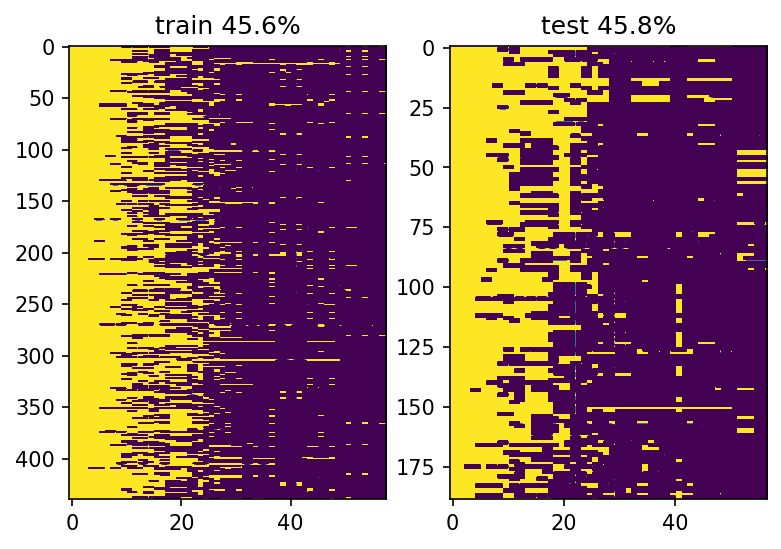

In [9]:
# Plot of missing values (in purple)
fig, axs = plt.subplots(1, 2, dpi=150)
axs[0].imshow(
    train_all.iloc[:, (np.argsort(train_all.isna().sum(axis=0)))].fillna(-99999999),
    aspect='auto', vmin=-9999, vmax=1)
axs[0].set_title(f'train {train_all.isna().sum().sum() / (train_all.shape[0] * train_all.shape[1]) :.1%}')
axs[1].imshow(
    test_all.iloc[:, (np.argsort(test_all.isna().sum(axis=0)))].fillna(-99999999),
    aspect='auto', vmin=-9999, vmax=1)
axs[1].set_title(f'test {test_all.isna().sum().sum() / (test_all.shape[0] * test_all.shape[1]) :.1%}')

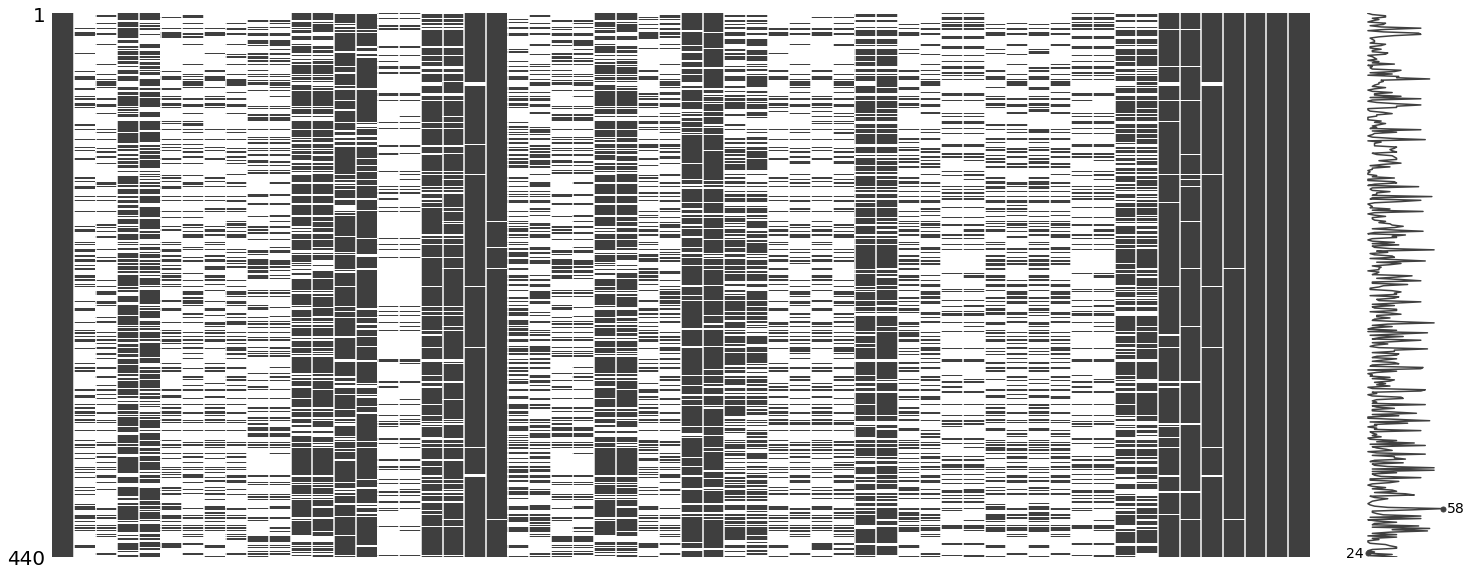

In [10]:
msno.matrix(train_all)

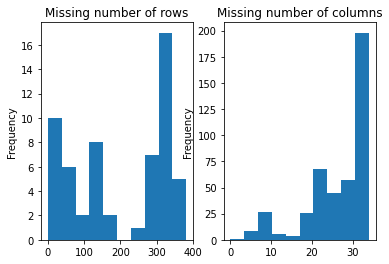

In [11]:
fig, axs = plt.subplots(1, 2)

train_all.isna().sum(axis=0).sort_values().plot.hist(title='Missing number of rows', ax=axs[0])
train_all.isna().sum(axis=1).sort_values().plot.hist(title='Missing number of columns', ax=axs[1])

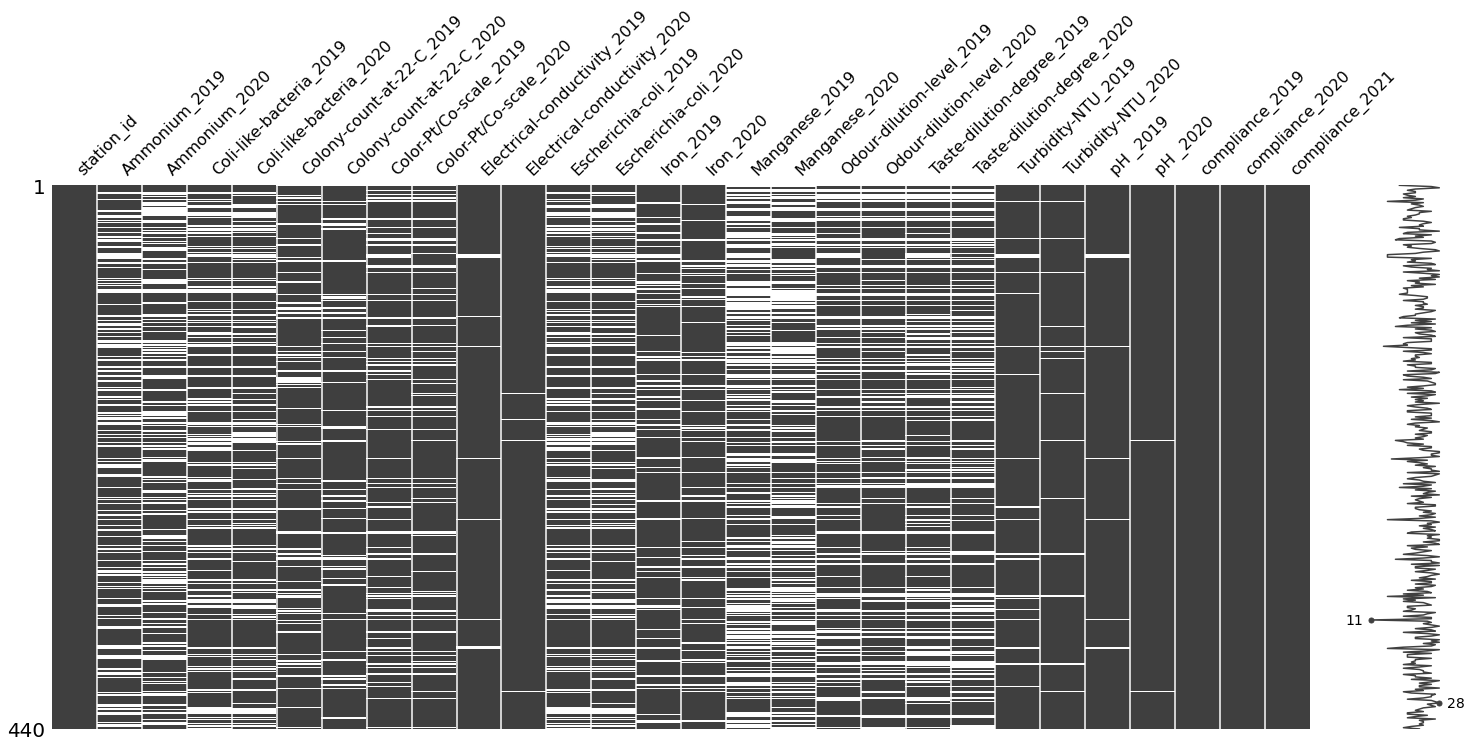

In [12]:
# print(train_all_Y[train_all.loc[train_all.isna().sum(axis=0) < 200].index].value_counts())
msno.matrix(train_all.loc[:, train_all.isna().sum(axis=0) < 200])

In [13]:
# Define endpoints
endpoint_names = ['compliance_2019', 'compliance_2020', 'compliance_2021']

Text(0.5, 1.0, 'Test')

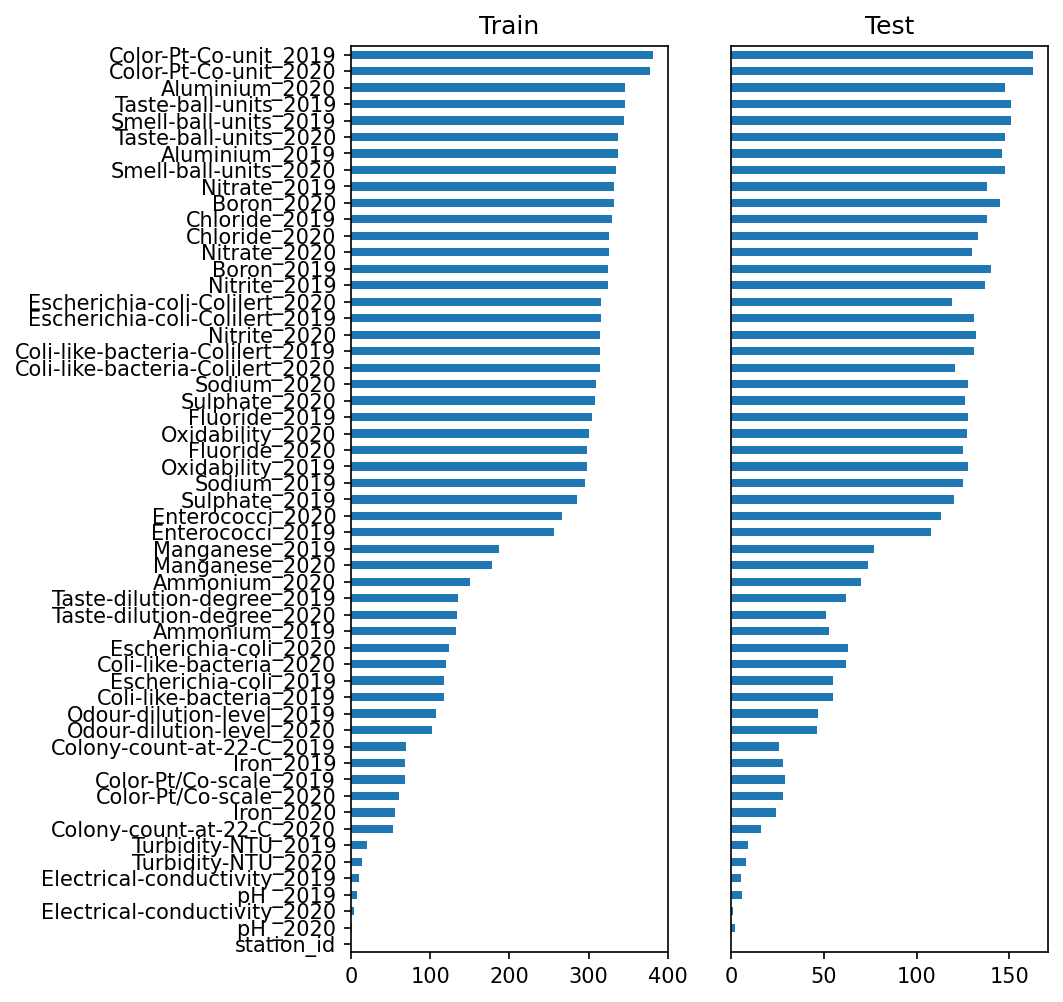

In [14]:
# Check which features have least missing values

fig, axs = plt.subplots(1, 2, figsize=(6, 8), dpi=150)


train_missing = train_all.loc[:, set(train_all.columns) - set(endpoint_names)].dropna(how='all', axis=1).isna().sum().sort_values()
test_missing = test_all.loc[:, set(test_all.columns) - set(endpoint_names)].dropna(how='all', axis=1).isna().sum().loc[train_missing.index]

train_missing.plot.barh(ax=axs[0])
test_missing.plot.barh(ax=axs[1])
axs[1].set_yticks([])
axs[0].set_title('Train')
axs[1].set_title('Test')


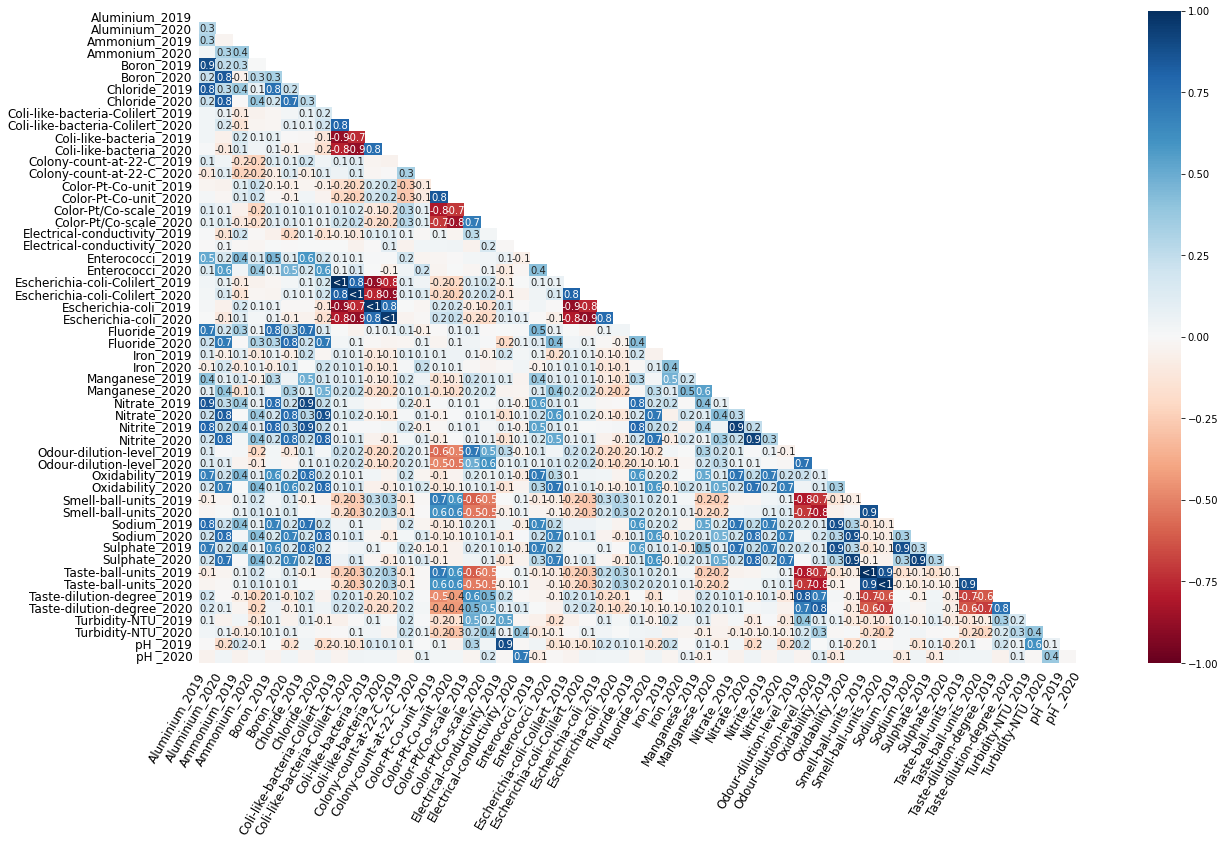

In [15]:
# NaN presence/absence correlations
msno.heatmap(train_all, fontsize=12, label_rotation=60)

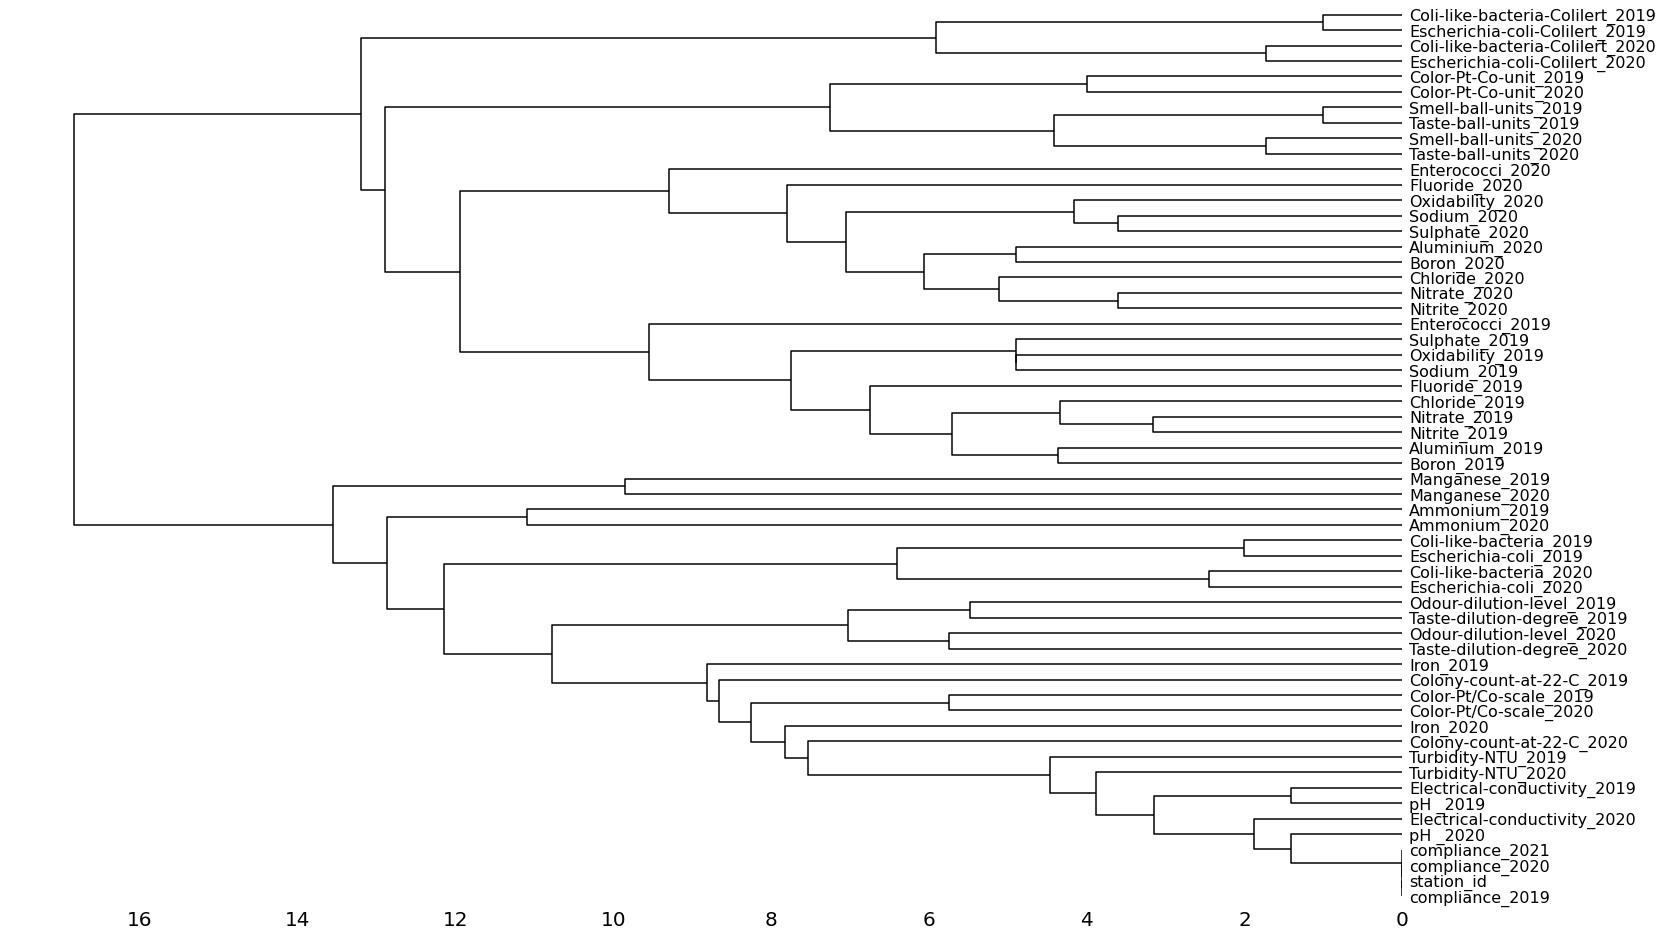

In [16]:
# Check if any unexpected feature groupings

msno.dendrogram(train_all)

In [17]:
# Extract the endpoint
train_all_Y = copy.deepcopy(train_all['compliance_2021'])
train_all = train_all.drop('compliance_2021', axis=1)

In [18]:
# Short overview of data
train_all.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
Aluminium_2019,103.0,16.932117,73.882649,0.002,5.000,10.0000,10.0000,754.000
Aluminium_2020,94.0,10.102528,12.298492,0.002,5.000,5.0000,10.0000,76.900
Ammonium_2019,307.0,0.139752,0.294113,0.027,0.050,0.0500,0.1400,3.500
Ammonium_2020,290.0,0.132352,0.236251,0.020,0.050,0.0500,0.1400,3.300
Boron_2019,116.0,0.321819,0.423732,0.002,0.100,0.1785,0.4035,3.700
Boron_2020,108.0,0.497083,0.939406,0.009,0.100,0.2525,0.5985,7.700
Chloride_2019,111.0,68.046847,95.549023,1.000,4.900,21.5000,99.5000,461.000
Chloride_2020,114.0,66.514912,84.631374,0.700,10.125,31.0000,98.4750,468.000
Coli-like-bacteria-Colilert_2019,125.0,20.708800,216.467309,0.000,0.000,0.0000,0.0000,2419.600
Coli-like-bacteria-Colilert_2020,125.0,1.307200,4.800843,0.000,0.000,0.0000,0.0000,33.000


## Feature engineering
This was logically done after "Feature correlations", but in order to keep notebook cells sequentially runnable, its is executed before

In [19]:
# Normalize data according to https://www.riigiteataja.ee/akt/111012013002 limits

LIMITS = {
    'Aluminium' : 200.0,
    'Ammonium' : 0.5,
    'Boron' : 1.0,
    'Chloride' : 250.0,
    'Electrical-conductivity' : 2500.0,
    'Colony-count-at-22-C' : 100.0,
    'Fluoride' : 1.5,
    'Iron' : 200,
    'Manganese' : 50,
    'Nitrate' : 50,
    'Nitrite' : 0.5,
    'Oxidability' : 5.0,
    'Sodium' : 200.0,
    'Sulphate' : 250,
    'Enterococci' : 0,
    'Escherichia-coli' : 0,
    # compliance here for binary history calculation later on. Duplicate will be dropped.
    'compliance' : 0

}


### transBinary

In [20]:
# New dataframes for storing engineered features
train_all_over_limit = copy.deepcopy(train_all)
test_all_over_limit = copy.deepcopy(test_all)

# Create binary indicators whether some feature has been over known limit at given year
def transBinary(static_df, mutate_df):

    for limit_name, limit_value in LIMITS.items():
        for col in static_df.columns:
            if limit_name not in col:
                continue
            year = col.split('_')[1]
            new_feature_name = limit_name + '_over_limit_' + year
            
            # Preserve NaN values
            value_comparison = (static_df[col] > limit_value).astype(int)
            nan_comparison = nan_comparison = static_df[[col]].notna().all(axis=1)

            mutate_df[new_feature_name] = value_comparison.where(nan_comparison)

# Apply transformation to both train and test set
transBinary(test_all, test_all_over_limit)
transBinary(train_all, train_all_over_limit)

In [21]:
train_all_over_limit

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Sodium_over_limit_2019,Sodium_over_limit_2020,Sulphate_over_limit_2019,Sulphate_over_limit_2020,Enterococci_over_limit_2019,Enterococci_over_limit_2020,Escherichia-coli_over_limit_2019,Escherichia-coli_over_limit_2020,compliance_over_limit_2019,compliance_over_limit_2020
0,487,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
1,1555,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
2,205,NaN,10.0,0.05,0.24,NaN,0.100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0
3,1228,NaN,NaN,0.09,0.05,0.641,0.932,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
4,470,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,830,NaN,NaN,0.36,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
436,803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
437,1081,NaN,5.0,NaN,0.27,NaN,0.274,NaN,14.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,1,1
438,458,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0


In [22]:
test_all_over_limit

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Sodium_over_limit_2019,Sodium_over_limit_2020,Sulphate_over_limit_2019,Sulphate_over_limit_2020,Enterococci_over_limit_2019,Enterococci_over_limit_2020,Escherichia-coli_over_limit_2019,Escherichia-coli_over_limit_2020,compliance_over_limit_2019,compliance_over_limit_2020
0,163,5.0,5.0,0.08,0.08,0.071,0.062,130.0,102.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,167,NaN,NaN,0.08,0.08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0
2,171,NaN,NaN,NaN,NaN,NaN,NaN,112.0,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,174,5.0,5.0,0.05,0.09,0.072,0.075,248.0,243.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0
4,178,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1941,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1,1
185,2087,5.0,NaN,NaN,NaN,0.855,NaN,417.0,NaN,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
186,2206,27.2,31.1,0.05,0.05,0.018,0.013,41.0,35.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,1
187,2303,NaN,5.0,NaN,0.05,NaN,0.147,NaN,40.0,0.0,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0,1


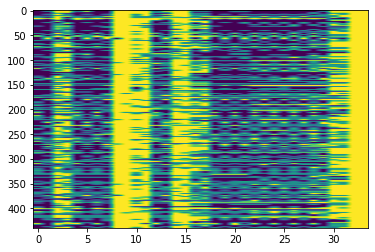

In [23]:
# Check if this created any useful variables
plt.imshow(train_all_over_limit.drop(train_all.columns, axis=1).fillna(-9999), aspect='auto', vmax=-9)

### transTertiary

In [24]:
# Create tertiary indicator whether a feature has been over limit 2019 and or 2020.
# Using weight 0.5 for 2019 and weight 1.0 for 2020
# Should be modifier accordingly if more yearly data should become available
def transTertiary(static_df, mutate_df):
    for feature in LIMITS.keys():
        tofind = feature + '_over_limit_'
        matches = np.array([feature for feature in mutate_df.columns if tofind in feature])
        matches_year = np.array([int(m.split('_')[-1]) for m in matches])
        matches = matches[np.argsort(matches_year)]
        weights = np.array([[0.5], [1.0]])
        out = mutate_df[matches].values @ weights
        new_colname = feature + '_bothyears'
        mutate_df[new_colname] = out.ravel()

transTertiary(test_all, test_all_over_limit)
transTertiary(train_all, train_all_over_limit)

In [25]:
train_all_over_limit[[s for s in train_all_over_limit if '_bothyears' in s]].describe()

,Aluminium_bothyears,Ammonium_bothyears,Boron_bothyears,Chloride_bothyears,Electrical-conductivity_bothyears,Colony-count-at-22-C_bothyears,Fluoride_bothyears,Iron_bothyears,Manganese_bothyears,Nitrate_bothyears,Nitrite_bothyears,Oxidability_bothyears,Sodium_bothyears,Sulphate_bothyears,Enterococci_bothyears,Escherichia-coli_bothyears,compliance_bothyears
count,44.000000,237.000000,56.000000,51.000000,426.0,343.000000,84.000000,347.000000,209.000000,50.0,59.0,77.000000,74.000000,74.0,117.000000,299.000000,440.000000
mean,0.011364,0.037975,0.044643,0.098039,0.0,0.166181,0.029762,0.146974,0.143541,0.0,0.0,0.006494,0.054054,0.0,0.017094,0.006689,0.298864
std,0.075378,0.202299,0.197180,0.360827,0.0,0.376688,0.179544,0.366614,0.358239,0.0,0.0,0.056980,0.269036,0.0,0.091247,0.057540,0.480720
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.500000
max,0.500000,1.500000,1.000000,1.500000,0.0,1.500000,1.500000,1.500000,1.500000,0.0,0.0,0.500000,1.500000,0.0,0.500000,0.500000,1.500000


### transDerivExtra

In [26]:
# Create a new features for each original yearly-pairwise-feature, which:
#   1. describes the absolute growth for that physio-chemical property (_deriv)
#   2. extrapolates that growth to next year (_extrap)

def transDerivExtra(static_df, mutate_df):
    years = sorted(list(set([int(s.split('_')[-1]) for s in static_df.columns if s.split('_')[-1].isdigit()])))
    properties = list(set([s.split('_')[0] for s in static_df.drop('station_id', axis=1).columns]))
    for prop in properties:
        select_both = np.array([s for s in static_df.columns if prop in s])
        matches_year = np.array([int(m.split('_')[-1]) for m in select_both])

        #sorted
        select_both = select_both[np.argsort(matches_year)]

        # calculate slope
        short_regr = lambda arra: sc.stats.linregress(range(len(arra)), arra).slope
        growth = static_df[select_both].apply(short_regr, axis=1)

        # extrapolate 1 year
        extrapolated = static_df[select_both[-1]] + growth

        # add new features to df
        growth_name = prop + '_deriv'
        extrapolated_name = prop + '_extrap'
        mutate_df[growth_name] = growth
        mutate_df[extrapolated_name] = extrapolated

transDerivExtra(test_all, test_all_over_limit)
transDerivExtra(train_all, train_all_over_limit)

### Encode missingness into a variable

In [27]:
train_all_over_limit.iloc[:, 0].apply(pd.isna).apply(int)

0      0
1      0
2      0
3      0
4      0
      ..
435    0
436    0
437    0
438    0
439    0
Name: station_id, Length: 440, dtype: int64

In [28]:
def transEncodeMissing(static_df, mutate_df):
    for col in mutate_df:
        new_colname = col + '_isMissing'
        mutate_df.loc[:, new_colname] = mutate_df.loc[:, col].apply(pd.isna).apply(int).values

transEncodeMissing(test_all, test_all_over_limit)
transEncodeMissing(train_all, train_all_over_limit)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


## Train/val split

In [29]:
from sklearn.model_selection import train_test_split

trainX_noneng, valX_noneng, trainY_noneng, valY_noneng = train_test_split(
    # train_all.loc[:, set(train_all.columns) - set(endpoint_names)],
    train_all.drop(['station_id'], axis=1),
    train_all_Y,
    random_state=421,
    stratify=train_all_Y,
    test_size=0.02
)

testX_noneng = test_all.drop(['station_id'], axis=1)


In [30]:
# Create training and validation sets
# Drop duplicate entries for compliance_YYYY

trainX, valX, trainY, valY = train_test_split(
    # train_all.loc[:, set(train_all.columns) - set(endpoint_names)],
    train_all_over_limit.drop(['station_id', 'compliance_over_limit_2019', 'compliance_over_limit_2020'], axis=1),
    train_all_Y,
    random_state=421,
    stratify=train_all_Y,
    test_size=0.005
)

testX = test_all_over_limit.drop(['station_id', 'compliance_over_limit_2019', 'compliance_over_limit_2020'], axis=1)

In [31]:
trainX_20, valX_20, trainY_20, valY_20 = train_test_split(
    # train_all.loc[:, set(train_all.columns) - set(endpoint_names)],
    train_all_over_limit.drop(['station_id', 'compliance_over_limit_2019', 'compliance_over_limit_2020'], axis=1),
    train_all_Y,
    random_state=421,
    stratify=train_all_Y,
    test_size=0.2
)

# testX = test_all_over_limit.drop(['station_id', 'compliance_over_limit_2019', 'compliance_over_limit_2020'], axis=1)

In [32]:
print(trainY.value_counts())
assert testX.shape[1] == trainX.shape[1]

0    371
1     66
Name: compliance_2021, dtype: int64


## Feature correlations

In [33]:
# Check for correlations with endpoint using kendall-tau coef

import scipy as sc
out = {}
for col in trainX:
    colset = trainX.loc[:, col].dropna()
    y_colset = trainY.loc[colset.index]
    out[col] = [sc.stats.kendalltau(colset.values, y_colset.values)[0], col, len(colset), np.sum(y_colset) / len(y_colset)]
    # print(sc.stats.kendalltau(colset.values, y_colset.values), col, len(col))
comparison_df = pd.DataFrame.from_dict(out, columns=['kt-coef','name','N_samples', '%_pos_class'], orient='index').sort_values('kt-coef')
    

In [34]:
comparison_df

,kt-coef,name,N_samples,%_pos_class
Aluminium_extrap,-0.264777,Aluminium_extrap,44,0.204545
Manganese_2020_isMissing,-0.191787,Manganese_2020_isMissing,437,0.151030
Manganese_over_limit_2020_isMissing,-0.191787,Manganese_over_limit_2020_isMissing,437,0.151030
Nitrite_extrap,-0.180184,Nitrite_extrap,59,0.186441
Sodium_over_limit_2020_isMissing,-0.158889,Sodium_over_limit_2020_isMissing,437,0.151030
...,...,...,...,...
compliance_over_limit_2019_isMissing,NaN,compliance_over_limit_2019_isMissing,437,0.151030
compliance_over_limit_2020_isMissing,NaN,compliance_over_limit_2020_isMissing,437,0.151030
compliance_bothyears_isMissing,NaN,compliance_bothyears_isMissing,437,0.151030
compliance_deriv_isMissing,NaN,compliance_deriv_isMissing,437,0.151030


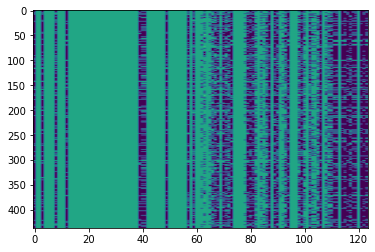

In [35]:
plt.imshow(trainX.loc[:, comparison_df.loc[(np.abs(comparison_df['kt-coef']) > 0.1), :].index].fillna(-9999), aspect='auto')

In [36]:
trainX.loc[:, comparison_df.loc[(np.abs(comparison_df['kt-coef']) > 0.1), :].index].isna().sum().sort_values()

Taste-ball-units_deriv_isMissing      0
Chloride_2020_isMissing               0
Sodium_2019_isMissing                 0
Sodium_over_limit_2019_isMissing      0
Enterococci_deriv_isMissing           0
                                   ... 
Color-Pt-Co-unit_extrap             384
Color-Pt-Co-unit_deriv              384
Chloride_deriv                      386
Chloride_extrap                     386
Aluminium_extrap                    393
Length: 124, dtype: int64

# Random Forest with KNN imputation

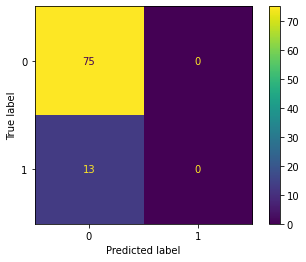

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

imputer = KNNImputer(n_neighbors=5, weights='distance')
# imputer = IterativeImputer()

# imputed_trainX = imputer.fit_transform(trainX_noneng)
# imputed_valX = imputer.transform(valX_noneng)
# imputed_testX = imputer.transform(testX_noneng)

imputed_trainX = imputer.fit_transform(trainX_20)
imputed_valX = imputer.transform(valX_20)
imputed_testX = imputer.transform(testX)

rfc1 = RandomForestClassifier(class_weight='balanced', n_estimators=111, oob_score=True, random_state=42, bootstrap=True, max_samples=0.66)
# rfc1.oob_score_
rfc1.fit(imputed_trainX, trainY_20)

ConfusionMatrixDisplay.from_estimator(rfc1, imputed_valX, valY_20)

0.8636363636363636


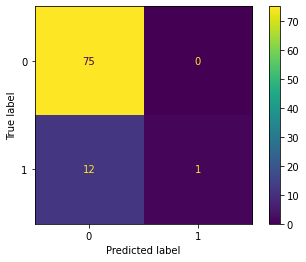

In [38]:
xgb_knn = xgb.XGBClassifier(subsample=0.88, seed=42, scale_pos_weight = 1, booster='gbtree', max_depth=6, eval_metric='logloss', objective='binary:logistic', learning_rate=0.0001, n_estimators=200, missing=-54321)
# rfc1.oob_score_
xgb_knn.fit(imputed_trainX, trainY_20)

print(xgb_knn.score(imputed_valX, valY_20))
ConfusionMatrixDisplay.from_estimator(xgb_knn, imputed_valX, valY_20)

# XGB with missing values + SMOTE

0.7840909090909091


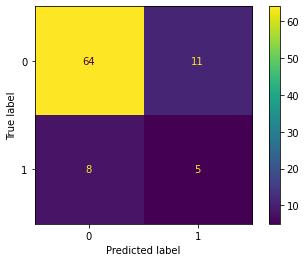

In [39]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours

trainX_smote, trainY_smote = EditedNearestNeighbours(n_neighbors=5).fit_resample(imputed_trainX, trainY_20)

rfc2 = xgb.XGBClassifier(subsample=0.92, seed=42, scale_pos_weight = 1, booster='gbtree', max_depth=5, eval_metric='logloss', objective='binary:logistic', learning_rate=0.0001, n_estimators=200, missing=-54321)
# rfc2 = RandomForestClassifier(class_weight='balanced', n_estimators=111, oob_score=True, random_state=42, bootstrap=True, max_samples=0.66)
# rfc1.oob_score_
rfc2.fit(trainX_smote, trainY_smote)

ConfusionMatrixDisplay.from_estimator(rfc2, imputed_valX, valY_20)
print(rfc2.score(imputed_valX, valY_20))

# RF with custom undersampling

In [40]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

rusX, rusY = rus.fit_resample(trainX_20, trainY_20)

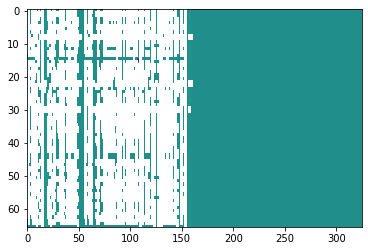

In [41]:
plt.imshow(trainX.loc[trainY == 1, :], aspect='auto')

In [42]:
from sklearn.tree import DecisionTreeClassifier
cbal = (np.sum(trainY) / (len(trainY) - np.sum(trainY) - 1))

rus = RandomUnderSampler(sampling_strategy='all', replacement=True)


gather = []
supported_features = []
decision_trees = []
for i in range(1000):
    # use_idx = trainX.sample(frac=1 - (np.sum(trainY) + 1) / len(trainY)).index
    use_idx = trainX_20.index

    rusX, rusY = rus.fit_resample(trainX_20.loc[use_idx, :], trainY_20.loc[use_idx])

    idxx = (rusX.isna().sum(axis=1) < rusX.isna().sum(axis=1).max() *0.9).index
    rusX = rusX.loc[idxx, :].sample(frac=0.05).dropna(axis=1)
    supported_features.append(set(list(rusX.columns)))
    gather += list(rusX.columns)

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(rusX, rusY.loc[rusX.index])

    decision_trees.append(copy.deepcopy(tree))

In [43]:
val_preds = []
for idx in valX_20.index:
    sample = valX_20.loc[idx, :].dropna()
    all_votes = []
    for tree_idx, tree in enumerate(decision_trees):
        suitable_features = supported_features[tree_idx]
        if suitable_features - set(sample.index) != set():
            continue
        
        this_pred = tree.predict(sample.loc[suitable_features].to_frame().T)
        all_votes.append(this_pred)
    if all_votes == []:
        val_preds.append(0)
    else:
        val_preds.append(sc.stats.mode(all_votes)[0][0][0])
# testX.loc[:, supported_features[10]]

Streaming output truncated to the last 5000 lines.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature 

In [151]:
print(classification_report(valY_20, val_preds))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        75
           1       0.27      0.23      0.25        13

    accuracy                           0.80        88
   macro avg       0.57      0.56      0.57        88
weighted avg       0.78      0.80      0.79        88



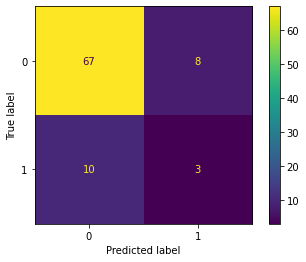

In [45]:
from sklearn.metrics import confusion_matrix
ConfusionMatrixDisplay.from_predictions(valY_20, val_preds)

# XGB with missing values

0.8522727272727273


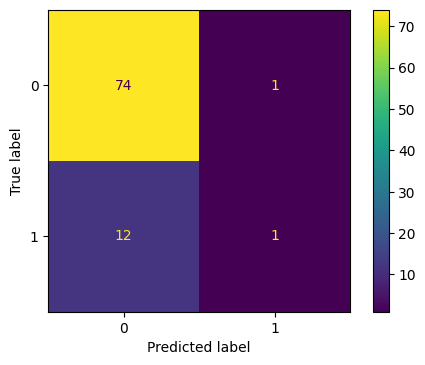

In [172]:

xgbc_20 = xgb.XGBClassifier(eval_metric='logloss', learning_rate=0.00014108310713325845,
              max_depth=4, n_estimators=1084, random_state=42,
              scale_pos_weight=4, seed=42, subsample=0.16539784556662676)
xgbc_20.fit(trainX_20, trainY_20.values)
ConfusionMatrixDisplay.from_estimator(xgbc_20, valX_20, valY_20)
print(xgbc_20.score(valX_20, valY_20))

1.0


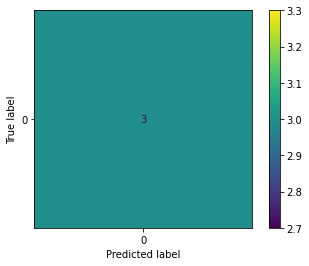

In [71]:
# Create an unoptimized XGB model

xgbc = xgb.XGBClassifier(subsample=0.92, seed=42, scale_pos_weight = 1, booster='gbtree', max_depth=5, eval_metric='logloss', objective='binary:logistic', learning_rate=0.0001, n_estimators=200, missing=np.nan)
xgbc.fit(trainX, trainY.values)
ConfusionMatrixDisplay.from_estimator(xgbc, valX, valY)
print(xgbc.score(valX, valY))

1.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

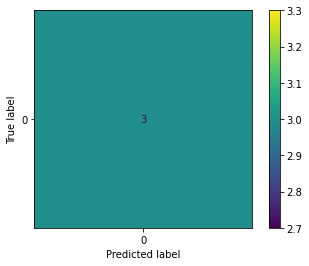

In [132]:
xgbc_simple = xgb.XGBClassifier(subsample=0.5, seed=42, scale_pos_weight = 3, booster='gbtree', max_depth=12, eval_metric='logloss', objective='binary:logistic', learning_rate=0.001, n_estimators=200, missing=np.nan)
xgbc_simple.fit(trainX, trainY.values)
ConfusionMatrixDisplay.from_estimator(xgbc_simple, valX, valY)
print(xgbc_simple.score(valX, valY))

In [48]:
# Use bayesian optimization and cross validation for parameter tuning

opt = skopt.BayesSearchCV(
    xgb.XGBClassifier(subsample=0.82, seed=42, scale_pos_weight = len(trainY) / np.sum(trainY), booster='gbtree', max_depth=6, eval_metric='logloss', objective='binary:logistic', learning_rate=0.0001, n_estimators=2000),
    {
        'subsample' : (0.1, 1.0, 'uniform'),
        'random_state' : [42],
        'learning_rate' : (1e-4, 0.9, 'log-uniform'),
        'max_depth' : (2, 12),
        'scale_pos_weight' : (1, 2*len(trainY) / np.sum(trainY), 'uniform'),
        'n_estimators' : (10, 301)
    },
    scoring='accuracy',
    n_iter=64,
    cv=10
)
opt.fit(trainX, trainY)

BayesSearchCV(cv=10,
              estimator=XGBClassifier(eval_metric='logloss',
                                      learning_rate=0.0001, max_depth=6,
                                      n_estimators=2000,
                                      scale_pos_weight=6.621212121212121,
                                      seed=42, subsample=0.82),
              n_iter=64, scoring='accuracy',
              search_spaces={'learning_rate': (0.0001, 0.9, 'log-uniform'),
                             'max_depth': (2, 12), 'n_estimators': (10, 301),
                             'random_state': [42],
                             'scale_pos_weight': (1, 13.242424242424242,
                                                  'uniform'),
                             'subsample': (0.1, 1.0, 'uniform')})

In [153]:
opt.best_estimator_

XGBClassifier(eval_metric='logloss', learning_rate=0.0004165689256145335,
              max_depth=4, n_estimators=35, random_state=42, scale_pos_weight=7,
              seed=42, subsample=0.1)

In [150]:

opt2 = skopt.BayesSearchCV(
    xgb.XGBClassifier(subsample=0.82, seed=42, scale_pos_weight = len(trainY) / np.sum(trainY), booster='gbtree', max_depth=6, eval_metric='logloss', objective='binary:logistic', learning_rate=0.0001, n_estimators=2000),
    {
        'subsample' : (0.001, 1.0, 'log-uniform'),
        'random_state' : [42],
        'learning_rate' : (1e-4, 0.9, 'log-uniform'),
        'max_depth' : (2, 12),
        'scale_pos_weight' : (1, 2*len(trainY) / np.sum(trainY), 'uniform'),
        'n_estimators' : (10, 3001)
    },
    scoring='accuracy',
    n_iter=64,
    cv=10
)
opt2.fit(trainX, trainY)

BayesSearchCV(cv=10,
              estimator=XGBClassifier(eval_metric='logloss',
                                      learning_rate=0.0001, max_depth=6,
                                      n_estimators=2000,
                                      scale_pos_weight=6.621212121212121,
                                      seed=42, subsample=0.82),
              n_iter=64, scoring='accuracy',
              search_spaces={'learning_rate': (0.0001, 0.9, 'log-uniform'),
                             'max_depth': (2, 12), 'n_estimators': (10, 3001),
                             'random_state': [42],
                             'scale_pos_weight': (1, 13.242424242424242,
                                                  'uniform'),
                             'subsample': (0.001, 1.0, 'log-uniform')})

In [152]:
opt2.best_estimator_

XGBClassifier(eval_metric='logloss', learning_rate=0.00014108310713325845,
              max_depth=5, n_estimators=1084, random_state=42,
              scale_pos_weight=4, seed=42, subsample=0.16539784556662676)

In [75]:
opt_estimator = opt.best_estimator_

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
No positive samples in y_true, true positive value should be meaningless


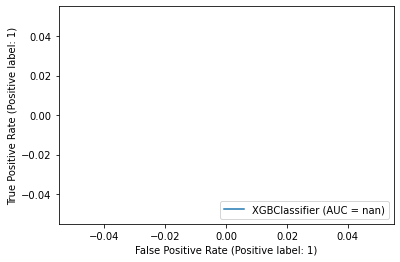

In [50]:
plot_roc_curve(xgbc, valX.fillna(-54321), valY)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
No positive samples in y_true, true positive value should be meaningless


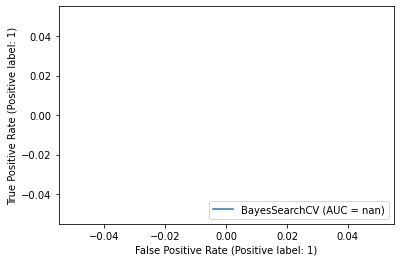

In [51]:
plot_roc_curve(opt, valX, valY)

In [52]:
print(opt.best_estimator_)
print(classification_report(valY, opt.predict(valX)))
print(opt.score(valX, valY))

XGBClassifier(eval_metric='logloss', learning_rate=0.0004165689256145335,
              max_depth=4, n_estimators=35, random_state=42, scale_pos_weight=7,
              seed=42, subsample=0.1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

1.0


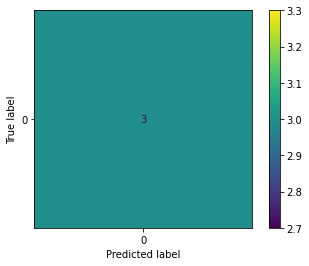

In [91]:
ConfusionMatrixDisplay.from_estimator(opt, valX, valY)

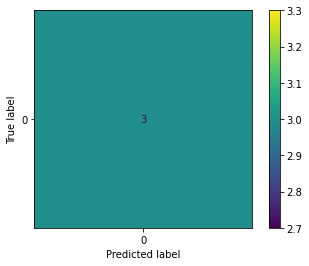

In [90]:
ConfusionMatrixDisplay.from_estimator(xgbc, valX, valY)

In [167]:
from sklearn.ensemble import StackingClassifier

estimators = [xgbc, xgbc_simple, opt_estimator, opt2.best_estimator_, xgbc]
final_pred = np.array([e.predict(testX) for e in estimators])

In [56]:
import copy
out_test = copy.deepcopy(test_all.loc[:, ['station_id']])
out_test['compliance_2021'] = xgbc.predict(testX.fillna(-54321))


In [169]:
sc.stats.mode(final_pred).mode

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [154]:
out_test = copy.deepcopy(test_all.loc[:, ['station_id']])
out_test['compliance_2021'] = opt2.predict(testX)
out_test.to_csv('sample_submission_eng_opt_5.csv', index=False)
!kaggle competitions submit -c copy-of-drinking-water-quality -f sample_submission_eng_opt_5.csv -m "sample_submission_eng_opt_5"

100% 1.20k/1.20k [00:01<00:00, 867B/s]
Successfully submitted to Drinking Water Quality Prediction (2)

# Model analysis

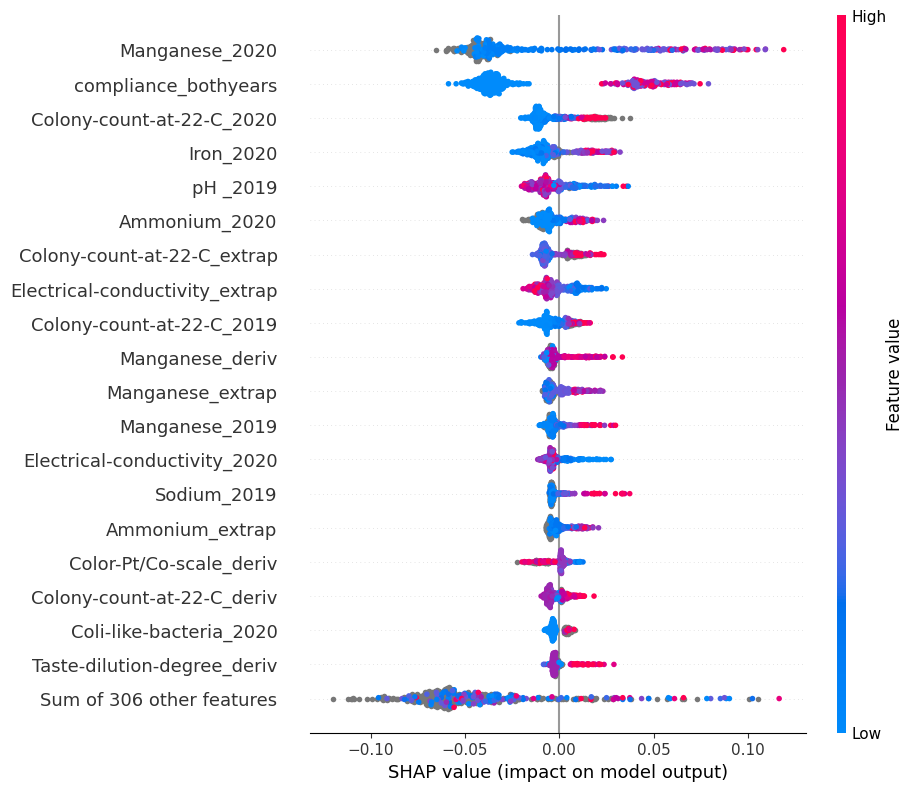

In [147]:
explainer = shap.TreeExplainer(xgbc_simple)
shap_values = explainer.shap_values(trainX)
shap_obj = explainer(trainX)
plt.rcParams['figure.dpi'] = 100
shap.plots.beeswarm(shap_obj, max_display=20)

In [62]:
explainer

# .IGNORE

In [63]:
# for limit_name, limit_value in LIMITS.items():
#     for col in train_all.columns:
#         if limit_name not in col:
#             continue
#         year = col.split('_')[1]
#         new_feature_name = limit_name + '_over_limit_' + year
        
#         # Preserve NaN values
#         value_comparison = (train_all[col] > limit_value).astype(int)
#         nan_comparison = nan_comparison = train_all[[col]].notna().all(axis=1)

#         train_all_over_limit[new_feature_name] = value_comparison.where(nan_comparison)

In [64]:
# for feature in LIMITS.keys():
#     tofind = feature + '_over_limit_'
#     matches = np.array([feature for feature in train_all_over_limit.columns if tofind in feature])
#     matches_year = np.array([int(m.split('_')[-1]) for m in matches])
#     matches = matches[np.argsort(matches_year)]
#     weights = np.array([[0.5], [1.0]])
#     out = train_all_over_limit[matches].values @ weights
#     new_colname = feature + '_bothyears'
#     train_all_over_limit[new_colname] = out.ravel()

In [65]:
# years = sorted(list(set([int(s.split('_')[-1]) for s in train_all.columns if s.split('_')[-1].isdigit()])))
# properties = list(set([s.split('_')[0] for s in train_all.drop('station_id', axis=1).columns]))
# for prop in properties:
#     select_both = np.array([s for s in train_all.columns if prop in s])
#     matches_year = np.array([int(m.split('_')[-1]) for m in select_both])

#     #sorted
#     select_both = select_both[np.argsort(matches_year)]
#     short_regr = lambda arra: sc.stats.linregress(range(len(arra)), arra).slope
#     growth = train_all[select_both].apply(short_regr, axis=1)
#     extrapolated = train_all[select_both[-1]] + growth
#     growth_name = prop + '_deriv'
#     extrapolated_name = prop + '_extrap'

#     train_all_over_limit[growth_name] = growth
#     train_all_over_limit[extrapolated_name] = extrapolated